<a href="https://colab.research.google.com/github/UnnatiChitra/Summary_Generation_LSTM/blob/main/Summary_Generation_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=8fcb4ea0db516c16a8d93f3ac47b9beebc48a824c446ad85b22e2e81f4e3d581
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import numpy as np
import spacy
from IPython.display import Image


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Setup some configuration parameters

config = {'min_text_len':40,
          'max_text_len':60,
          'max_summary_len':30,
          'latent_dim' : 300,
          'embedding_dim' : 200}

---
# Reading the dataset
---

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!gdown 1sui9RXxVsPDa4s2kooQwRGhb8taZhcgD
!gdown 1H3gdo7SLBiWE_GGD6_xcdAp2wJJFcd5L

In [ ]:
from rouge_score import rouge_scorer

summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

raw = raw.rename(columns = {'headlines':'summary'})
summary = summary[['headlines', 'text']].rename(columns={'headlines':'summary'})

# Concatenate the summary and the raw files
df = pd.concat([raw, summary]).reset_index(drop=True)

summary.shape, raw.shape

### Distribution of words before filtering

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,2.5))
sns.boxplot(raw.text.str.split().str.len(), ax=ax[0])
ax[0].set_title('text')
sns.boxplot(raw.summary.str.split().str.len(), ax=ax[1])
ax[1].set_title('summary')

fig.show()

### Filter text in the range between 40 and 60 words

In [ ]:
print(f'Before filtering: {raw.shape}')
pre = df.loc[((df['text'].str.split(" ").str.len()>config['min_text_len'])
               &(df['text'].str.split(" ").str.len()<config['max_text_len']))].reset_index(drop=True)
print(f'After filtering: {pre.shape}')

### Distribution of words after filtering

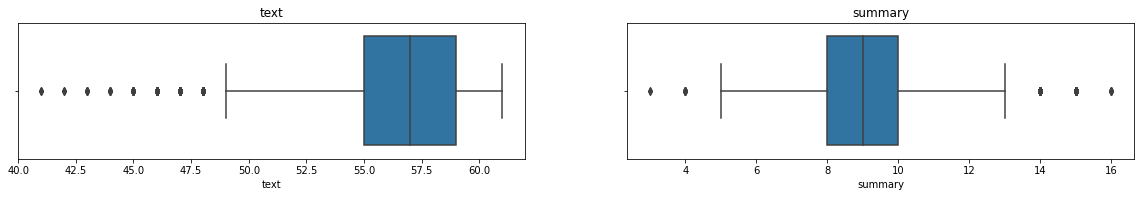

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,2.5))
sns.boxplot(pre.text.str.split().str.len(), ax=ax[0])
ax[0].set_title('text')
sns.boxplot(pre.summary.str.split().str.len(), ax=ax[1])
ax[1].set_title('summary')

fig.show()

In [ ]:
ind = 1
print(f'Text: {pre.text[ind]}')
print()
print(f'Summary: {pre.summary[ind]}')
print()
print(f'Text length: {len(pre.text[ind].split())}')
print(f'Summary length: {len(pre.summary[ind].split())}')


Text: India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108.

Summary: India get all out for 92, their lowest ODI total in New Zealand

Text length: 56
Summary length: 13


In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import spacy
from time import time
import numpy as np


# Text preprocessing

In [ ]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(sentence):

    sentence = re.sub("(\\t)", " ", str(sentence)).lower()
    sentence = re.sub("(\\r)", " ", str(sentence)).lower()
    sentence = re.sub("(\\n)", " ", str(sentence)).lower()

    # Remove - if it occurs more than one time consecutively
    sentence = re.sub("(--+)", " ", str(sentence)).lower()

    # Remove . if it occurs more than one time consecutively
    sentence = re.sub("(\.\.+)", " ", str(sentence)).lower()

    # Remove the characters - <>()|&©ø"',;?~*!
    sentence = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(sentence)).lower()

    # Remove \x9* in text
    sentence = re.sub(r"(\\x9\d)", " ", str(sentence)).lower()

    # Replace CM# and CHG# to CM_NUM
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(sentence)).lower()

    # Remove punctuations at the end of a word
    sentence = re.sub("(\.\s+)", " ", str(sentence)).lower()
    sentence = re.sub("(\-\s+)", " ", str(sentence)).lower()
    sentence = re.sub("(\:\s+)", " ", str(sentence)).lower()

    # Remove multiple spaces
    sentence = re.sub("(\s+)", " ", str(sentence)).lower()

    return sentence

# Get the cleaned text and Add start, end tokens

In [ ]:
pre['cleaned_text'] = pre.text.apply(lambda x: text_strip(x))
pre['cleaned_summary'] = pre.summary.apply(lambda x: '_START_ '+ text_strip(x) + ' _END_')
pre['cleaned_summary'] = pre['cleaned_summary'].apply(lambda x: 'sostok ' + x + ' eostok')
pre

,summary,text,cleaned_text,cleaned_summary
0,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan has deni...,sostok _START_ rahat fateh ali khan denies get...
1,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...,india recorded their lowest odi total in new z...,sostok _START_ india get all out for 92 their ...
2,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...,andhra pradesh cm n chandrababu naidu has said...,sostok _START_ called pm modi sir 10 times to ...
3,81-yr-old woman conducts physical training in ...,"Isha Ghosh, an 81-year-old member of Bharat Sc...",isha ghosh an 81-year-old member of bharat sco...,sostok _START_ 81-yr-old woman conducts physic...
4,"Karan Johar, Tabu turn showstoppers on opening...",Filmmaker Karan Johar and actress Tabu turned ...,filmmaker karan johar and actress tabu turned ...,sostok _START_ karan johar tabu turn showstopp...
...,...,...,...,...
54567,Prosthetic fingers on sale to rig UP election:...,An investigation by India Today has unmasked a...,an investigation by india today has unmasked a...,sostok _START_ prosthetic fingers on sale to r...
54568,"Kangana, Shahid, Saif starrer 'Rangoon' hits t...","The Kangana Ranaut, Shahid Kapoor and Saif Ali...",the kangana ranaut shahid kapoor and saif ali ...,sostok _START_ kangana shahid saif starrer ran...
54569,Ticket collector bites off senior officer?s no...,A ticket collector on Thursday allegedly bit o...,a ticket collector on thursday allegedly bit o...,sostok _START_ ticket collector bites off seni...
54570,Shouldn't rob their childhood: Aamir on kids r...,"Aamir Khan, while talking about reality shows ...",aamir khan while talking about reality shows o...,sostok _START_ shouldn t rob their childhood a...


In [ ]:
print(pre.shape)
post_pre = pre[((pre.cleaned_text.str.split().str.len()<=config['max_text_len']) &
                (pre.summary.str.split().str.len()<=(config['max_summary_len']+4)))].copy()
post_pre = post_pre.reset_index(drop=True)
print(post_pre.shape)

post_pre = post_pre.drop(['text', 'summary'], axis=1)
post_pre = post_pre.rename(columns = {'cleaned_text':'text',
                                      'cleaned_summary':'summary'})
post_pre

(54572, 4)
(47500, 4)


,text,summary
0,pakistani singer rahat fateh ali khan has deni...,sostok _START_ rahat fateh ali khan denies get...
1,india recorded their lowest odi total in new z...,sostok _START_ india get all out for 92 their ...
2,andhra pradesh cm n chandrababu naidu has said...,sostok _START_ called pm modi sir 10 times to ...
3,isha ghosh an 81-year-old member of bharat sco...,sostok _START_ 81-yr-old woman conducts physic...
4,filmmaker karan johar and actress tabu turned ...,sostok _START_ karan johar tabu turn showstopp...
...,...,...
47495,indian captain virat kohli on friday got out w...,sostok _START_ virat kohli out for a duck for ...
47496,srinivas kunchubhotla 32 an indian engineer wa...,sostok _START_ indian shot dead in us over all...
47497,an investigation by india today has unmasked a...,sostok _START_ prosthetic fingers on sale to r...
47498,a ticket collector on thursday allegedly bit o...,sostok _START_ ticket collector bites off seni...


# Split the train and validation dataset

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(post_pre["text"]),
                                            np.array(post_pre["summary"]),
                                            test_size=0.1,
                                            random_state=0,
                                            shuffle=True
                                           )

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((42750,), (4750,), (42750,), (4750,))

In [ ]:
def get_rare_words(text_col):

    # Prepare a tokenizer on testing data
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(list(text_col))

    thresh = 5

    cnt = 0
    tot_cnt = 0

    for key, value in text_tokenizer.word_counts.items():
        tot_cnt = tot_cnt + 1
        if value < thresh:
            cnt = cnt + 1

    print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

    return cnt, tot_cnt

### Tokenize the train dataset

In [ ]:
x_train_cnt, x_train_tot_cnt = get_rare_words(text_col=x_train)

% of rare words in vocabulary: 64.22363847045192


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words=x_train_tot_cnt - x_train_cnt)
# x_tokenizer = Tokenizer(num_words = x_train_tot_cnt)
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_valid)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=config['max_text_len'], padding='post')
x_val = pad_sequences(x_val_seq, maxlen=config['max_text_len'], padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 20996


### Tokenize the validation dataset

In [ ]:
y_train_cnt, y_train_tot_cnt = get_rare_words(text_col=y_train)

% of rare words in vocabulary: 66.49736426949863


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=y_train_tot_cnt - y_train_cnt)
# y_tokenizer = Tokenizer(num_words=y_train_tot_cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_valid)

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=config['max_summary_len'], padding='post')
y_val = pad_sequences(y_val_seq, maxlen=config['max_summary_len'], padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 8708


In [ ]:
latent_dim = config['latent_dim']
embedding_dim = config['embedding_dim']
max_text_len = config['max_text_len']
max_summary_len = config['max_summary_len']

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 200)      4199200     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

# Compile and train the model

In [ ]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_name = "./model.h5"

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=500,
    callbacks=[es, save_model],
    batch_size=1024,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
    )

Epoch 1/500
42/42 [==============================] - ETA: 0s - loss: 4.5180 - accuracy: 0.5909
Epoch 1: val_loss improved from inf to 2.78202, saving model to ./model.h5
42/42 [==============================] - 71s 1s/step - loss: 4.5180 - accuracy: 0.5909 - val_loss: 2.7820 - val_accuracy: 0.6204
Epoch 2/500
42/42 [==============================] - ETA: 0s - loss: 2.7255 - accuracy: 0.6229
Epoch 2: val_loss improved from 2.78202 to 2.66276, saving model to ./model.h5
42/42 [==============================] - 68s 2s/step - loss: 2.7255 - accuracy: 0.6229 - val_loss: 2.6628 - val_accuracy: 0.6298
Epoch 3/500
42/42 [==============================] - ETA: 0s - loss: 2.7010 - accuracy: 0.6477
Epoch 3: val_loss improved from 2.66276 to 2.53363, saving model to ./model.h5
42/42 [==============================] - 60s 1s/step - loss: 2.7010 - accuracy: 0.6477 - val_loss: 2.5336 - val_accuracy: 0.6820
Epoch 4/500
42/42 [==============================] - ETA: 0s - loss: 2.5031 - accuracy: 0.6858


In [ ]:
model.load_weights('./model.h5')

In [ ]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0) and (i != target_word_index['sostok']) and (i != target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '

    return newString

# Prediction summary

In [ ]:
actual = []
predicted = []
for i in range(0, 50):
    print ('Review:', seq2text(x_tr[i]))

    actual.append(seq2summary(y_tr[i]))
    print ('Original summary:', actual[-1])

    predicted.append(decode_sequence(x_tr[i].reshape(1, config['max_text_len'])))
    print ('Predicted summary:', predicted[-1])
    print()

prediction_df = pd.DataFrame({'Actual':actual, 'Predicted':predicted})
prediction_df.head(10)

Review: actress deepika padukone has denied reports that she is portraying amrita pritam in an upcoming biopic on poet ludhianvi which is being produced by sanjay leela bhansali deepika has currently signed only vishal bhardwaj s next production where she will be the role of gangster khan who was popularly known as sapna didi 
Original summary: start deepika denies starring as amrita in bhansali s film end 
Predicted summary:  start deepika to play in biopic on padmavati row report end

Review: neelima azim while talking about being a single mother and sons shahid kapoor and ishaan khatter said i was a single mother and till today he shahid is taking care of ishaan and me in every way he took our lives forward in mumbai we started living better we had all the and comfort she added 
Original summary: start shahid takes care of ishaan me on being single mom end 
Predicted summary:  start my son taimur is a dream to be a on my burkha end

Review: an etihad airways pilot passed away on wed

,Actual,Predicted
0,start deepika denies starring as amrita in bha...,start deepika to play in biopic on padmavati ...
1,start shahid takes care of ishaan me on being ...,start my son taimur is a dream to be a on my ...
2,start pilot dies on board airways plane mid ai...,start pilot flyers to fly plane with emergenc...
3,start celebrations begin at ram nath kovind s ...,start pm modi to be called by a dictator in u...
4,start guest their heads in protest in mp end,start women wear skirts in protest against end
5,start can t tolerate weinstein like behaviour ...,start i don t know how to be used to stop fac...
6,start gujarat poll panel orders probe in contr...,start ec orders removal of using fake news on...
7,start facebook suspends canadian firm amid dat...,start facebook suspends facebook over fake ne...
8,start iraq s first non arab president passes a...,start iraq s 1st state citizen to be held in ...
9,start us scientists propose new organ in human...,start scientists propose new type of human sy...


---
# Rouge score
---

In [ ]:
r_score = []
rouge_pr = []
rouge_rc = []
rouge_f = []

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for indx, data in prediction_df.iterrows():
    r_score = scorer.score(data.Actual, data.Predicted)
    pr = list(r_score['rouge1'])[0]
    rc = list(r_score['rouge1'])[1]
    fmeas = list(r_score['rouge1'])[2]

    rouge_pr.append(pr)
    rouge_rc.append(rc)
    rouge_f.append(fmeas)

prediction_df['rouge_pr'] = rouge_pr
prediction_df['rouge_rc'] = rouge_rc
prediction_df['rouge_f'] = rouge_f
prediction_df.head(10)

,Actual,Predicted,rouge_pr,rouge_rc,rouge_f
0,start deepika denies starring as amrita in bha...,start deepika to play in biopic on padmavati ...,0.363636,0.363636,0.363636
1,start shahid takes care of ishaan me on being ...,start my son taimur is a dream to be a on my ...,0.285714,0.333333,0.307692
2,start pilot dies on board airways plane mid ai...,start pilot flyers to fly plane with emergenc...,0.400000,0.400000,0.400000
3,start celebrations begin at ram nath kovind s ...,start pm modi to be called by a dictator in u...,0.166667,0.200000,0.181818
4,start guest their heads in protest in mp end,start women wear skirts in protest against end,0.500000,0.444444,0.470588
5,start can t tolerate weinstein like behaviour ...,start i don t know how to be used to stop fac...,0.266667,0.400000,0.320000
6,start gujarat poll panel orders probe in contr...,start ec orders removal of using fake news on...,0.250000,0.272727,0.260870
7,start facebook suspends canadian firm amid dat...,start facebook suspends facebook over fake ne...,0.600000,0.600000,0.600000
8,start iraq s first non arab president passes a...,start iraq s 1st state citizen to be held in ...,0.333333,0.400000,0.363636
9,start us scientists propose new organ in human...,start scientists propose new type of human sy...,0.666667,0.600000,0.631579
